In [1]:
from src.blocksworld.blocksworld_with_possible_actions import BlocksworldChatWithPossibleActions
import yaml
from pathlib import Path

from collections import deque
import networkx as nx

import matplotlib.pyplot as plt

import random
import copy
from networkx.drawing.nx_pydot import graphviz_layout
import pydot

In [2]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [52]:
run_config = yaml.safe_load(open("configs/run.yaml"))
config = yaml.safe_load(open("configs/blocksworld_chat_with_possible_actions.yaml"))

config = {**config, **run_config}

dataset_folder = Path(config["dataset_folder"])
instance = dataset_folder / f"instance_{38}"

few_shot = instance / "few_shot.txt"
ground_truth_plan = instance / "ground_truth_plan.txt"
ground_truth_plan = open(ground_truth_plan, "r").read()
pddl_file = instance / "pddl.pddl"
config["few_shot"] = few_shot
config["ground_truth_plan"] = ground_truth_plan
config["pddl_file"] = pddl_file


engine = BlocksworldChatWithPossibleActions(model=None, config=config)

In [53]:
G = nx.Graph()

In [54]:
def get_first_letter(string: str):
    return string[0]

def state_to_string(state: list):
    string = ""
    predicates_strings = []
    for predicate in state:
        predicate_string = str(predicate)[1:].split(" ")
        predicate_string = "".join(map(get_first_letter, predicate_string))
        predicates_strings.append(predicate_string)
    predicates_strings.sort()
    return "_".join(predicates_strings)

In [55]:
engine.problem_state.current_state_predicate_list

[Predicate(handempty, ),
 Predicate(ontable, c),
 Predicate(clear, c),
 Predicate(clear, b),
 Predicate(on, b, a),
 Predicate(ontable, a)]

In [56]:
state_to_string(engine.problem_state.current_state_predicate_list)

'cb_cc_h_oa_oba_oc'

In [57]:
class State_Hashtable:
    def __init__(self):
        self.table = {}
        self.length = 0

    def add(self, state, parent_state, depth):
        state_string = state_to_string(state.problem_state.current_state_predicate_list)
        if not self.table.get(state_string, None):
            self.table[state_string] = (self.length, state, parent_state, depth)
            self.length += 1

    def get(self, state):
        state_string = state_to_string(state.problem_state.current_state_predicate_list)
        if state_string in self.table:
            return self.table[state_string]
        return None
    
    def is_in(self, state):
        state_string = state_to_string(state.problem_state.current_state_predicate_list)
        
        return self.table.get(state_string, None) != None

    def __len__(self):
        return len(self.table)
    
    def __str__(self):
        return str(self.table)

In [58]:
def BFS(engine, depth=-1):
    G = nx.DiGraph()
    q = deque()
    q.append(engine)
    hash_table = State_Hashtable()
    hash_table.add(engine, None, 0)
    G.add_node(hash_table.get(engine)[0], engine=engine)
    while len(q) != 0:
        current_engine = q.popleft()
        if depth != -1 and hash_table.get(current_engine)[3] >= depth:
            return None, hash_table, G
        if current_engine.problem_state.goal_reached():
            return current_engine, hash_table, G
        possible_actions = current_engine.problem_state.get_all_possible_actions()
        for possible_action in possible_actions:
            new_engine = copy.deepcopy(current_engine)
            new_engine.problem_state.take_action(*possible_action)
            #G.add_node(hash_table.get(new_engine)[0], engine=new_engine)
            #G.add_edge(hash_table.get(current_engine)[0], hash_table.get(new_engine)[0], action=current_engine.action_to_text(possible_action))
            if not hash_table.is_in(new_engine):
                hash_table.add(new_engine, current_engine, hash_table.get(current_engine)[3] + 1)
                q.append(new_engine)
                G.add_node(hash_table.get(new_engine)[0], engine=new_engine)
                G.add_edge(hash_table.get(current_engine)[0], hash_table.get(new_engine)[0], action=current_engine.action_to_text(possible_action))
            if new_engine.problem_state.goal_reached():
                return new_engine, hash_table, G
            
    return None, hash_table, G

In [59]:
goal_state, hash_table, G = BFS(engine)
G_undirect = G.to_undirected()
pos = pos = hierarchy_pos(G_undirect, 0)

In [60]:
engine.goal_to_text()

'My goal is to have the orange block on top of the red block.\n'

In [61]:
hash_table.get(goal_state)

(10,
 4)

In [62]:
def get_path_to_goal(hash_table, G, goal_state): 
    state_sequence = []
    actions_sequence = []

    state_id, current_state, parent_state, _ = hash_table.get(goal_state)
    state_sequence.append(current_state)
    while parent_state != None:
        child_state_id = state_id
        state_id, current_state, parent_state, _ = hash_table.get(parent_state)
        action = G.get_edge_data(state_id, child_state_id)["action"]
        actions_sequence.append(action)
        state_sequence.append(current_state)
        current_state = parent_state
        
    return state_sequence[::-1], actions_sequence[::-1]

In [63]:
state_sequence, actions_sequence = get_path_to_goal(hash_table, G, goal_state)

In [70]:
engine.current_state_to_text()

'As current conditions I have that the blue block is clear, the blue block is on top of the red block, the hand is empty, the orange block is clear, the orange block is on the table, the red block is on the table.\n'

In [64]:
actions_sequence

['unstack the blue block from on top of the red block',
 'put down the blue block',
 'pick up the orange block',
 'stack the orange block on top of the red block']

In [65]:
state_to_string(G.nodes[4]["engine"].problem_state.current_state_predicate_list)

'ca_cb_h_oa_obc_oc'

In [66]:
hash_table.get(G.nodes[0]["engine"])

(0,
 None,
 0)

In [67]:
edge_labels = {(edge[0], edge[1]): edge[2]["action"] for edge in list(G.edges(data=True))}

In [68]:
edge_labels

{(0, 1): 'unstack the blue block from on top of the red block',
 (0, 2): 'pick up the orange block',
 (1, 3): 'put down the blue block',
 (1, 4): 'stack the blue block on top of the orange block',
 (2, 5): 'stack the orange block on top of the blue block',
 (3, 6): 'pick up the orange block',
 (3, 7): 'pick up the red block',
 (4, 8): 'pick up the red block',
 (6, 9): 'stack the orange block on top of the blue block',
 (6, 10): 'stack the orange block on top of the red block'}

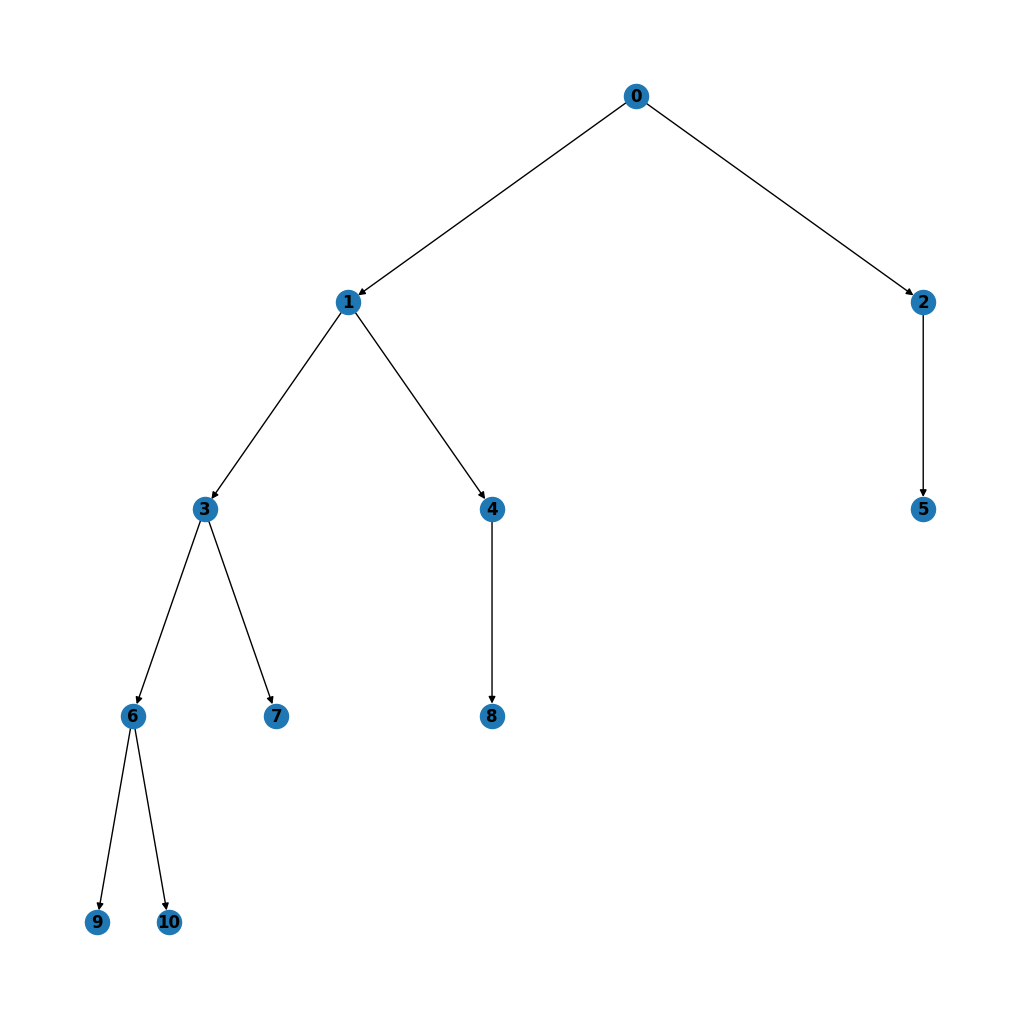

In [69]:
fig = plt.figure(figsize=(10, 10))

nx.draw(G, with_labels=True, font_weight='bold', pos=pos)
"""nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='red',
    font_size=6,
    label_pos=0.3,
);""";

In [201]:
G.edges(2)

OutEdgeDataView([(2, 0), (2, 5)])

In [196]:
nx.ancestors(G, hash_table.get(goal_state)[0])

{0, 1, 2}

In [65]:
G.get_edge_data(6, 14)

{'action': 'unstack the red block from on top of the yellow block'}

In [ ]:
engine.

In [ ]:
engine.current_state_to_text()

In [23]:
engine.current_state_to_text()

'As current conditions I have that the blue block is clear, the blue block is on the table, the hand is empty, the orange block is on the table, the red block is clear, the red block is on top of the yellow block, the yellow block is on top of the orange block.\n'